In [71]:
%matplotlib inline
import matplotlib.pyplot as plt
import json
import datetime
import pandas as pd
import numpy as np

from pprint import pprint

with open('./data/Chrome/BrowserHistory.json') as data_file:    
    data = json.load(data_file)

chrome_df = pd.DataFrame(data["Browser History"])

In [90]:
### Lets just take a look at what we're dealing with
chrome_df.head(5)

,client_id,favicon_url,page_transition,time_usec,title,url,timestamp,month,day,year,day_of_week,hour,site
0,XRikG+jrTrzYJXOKoPqPBw==,https://www.google.com/favicon.ico,LINK,1486837461033180,Data tools - Download your data,https://takeout.google.com/settings/takeout,1486837461,Feb,11,2017,Sat,0,google
1,XRikG+jrTrzYJXOKoPqPBw==,https://www.google.com/images/branding/product...,GENERATED,1486837456932528,google takeout - Google Search,https://www.google.com/webhp?sourceid=chrome-i...,1486837456,Feb,11,2017,Sat,0,google
2,XRikG+jrTrzYJXOKoPqPBw==,https://www.google.com/favicon.ico,TYPED,1486837452643311,New Tab,chrome://newtab/,1486837452,Feb,11,2017,Sat,0,NaN
3,XRikG+jrTrzYJXOKoPqPBw==,http://localhost:8888/static/base/images/favic...,LINK,1486837398357941,chrome,http://localhost:8888/notebooks/chrome.ipynb,1486837398,Feb,11,2017,Sat,0,NaN
4,XRikG+jrTrzYJXOKoPqPBw==,http://localhost:8888/static/base/images/favic...,AUTO_TOPLEVEL,1486837382127983,Home,http://localhost:8888/tree?token=16b29b27dfb74...,1486837382,Feb,11,2017,Sat,0,NaN


In [79]:
### Make these dates usable
def get_month_day_hour(timestamp):
    date = datetime.date.fromtimestamp(timestamp)

    return (date.strftime('%b'), int(date.strftime('%-d')), int(date.strftime('%Y')), date.strftime('%a'), date.strftime('%-H'))

chrome_df['timestamp'] = (chrome_df['time_usec']/1000000).astype(int) # in microseconds
chrome_df['month'], chrome_df['day'], chrome_df['year'], chrome_df['day_of_week'], chrome_df['hour'] = zip(*chrome_df["timestamp"].map(get_month_day_hour))

In [4]:
### Filter urls

In [80]:
chrome_df['site'] = chrome_df['url'].str.extract('\.(\w+)(?:\.com|\.org|\.net|\.co)', expand=False)

In [84]:
### Plot some data
len(chrome_df.index)

7742

In [85]:
chrome_df['site'].value_counts().sort_values(ascending=False).head(20)

google         1769
ycombinator     310
futurelearn     146
pb              133
yahoo           117
facebook         85
librato          75
paypal           74
edx              73
coursera         64
amazon           58
booking          51
shutterfly       47
airbnb           46
aa               41
hipmunk          39
youtube          39
divinvest        36
postgresql       30
wikipedia        30
Name: site, dtype: int64

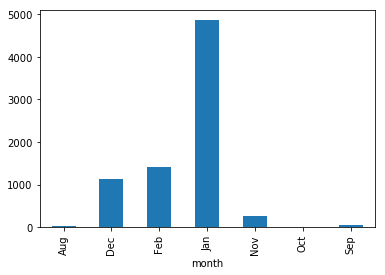

In [86]:
chrome_df[['month', 'client_id']].groupby("month").agg(['count']).plot(kind="bar", legend=False)

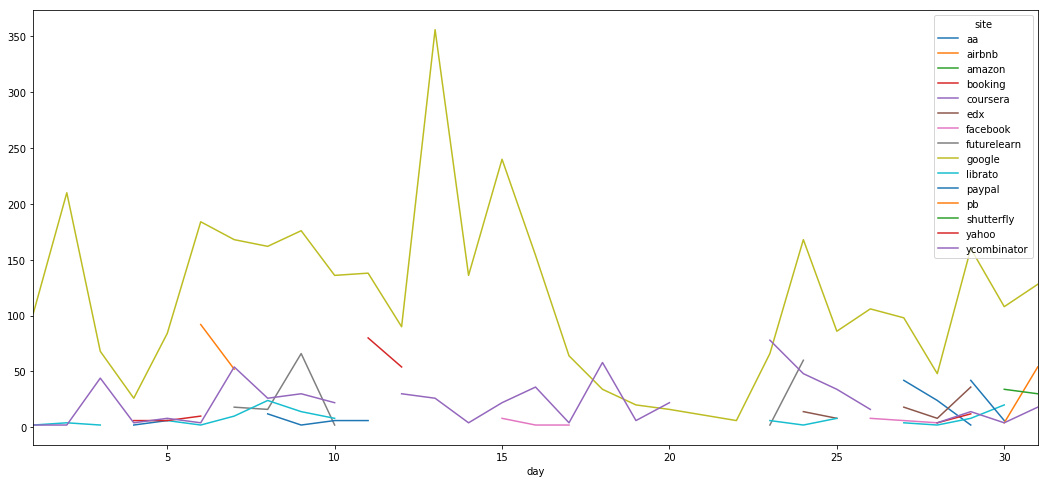

In [89]:
#chrome_df.groupby("site").plot(kind="line", x="day", sharex=True)
top_sites = chrome_df.groupby(['site']).count().sort_values(by='title', ascending=False).head(15).index
top_sites_df = chrome_df[chrome_df['site'].isin(top_sites)]
pd.pivot_table(top_sites_df[['site', 'day']], columns='site', index='day', aggfunc=np.count_nonzero).plot(figsize=(18,8))

In [82]:
## Lets run a test
### Just for fun

In [94]:
"""
I have a hypothesis...

I think that its more likely that i browse more websites on Friday, rather than Saturday.
This may not sound like an interesting test. And you're right, but this is my blog
"""

'\nI have a hypothesis...\n\nI think that its more likely that i browse more websites on Friday, rather than Saturday.\n'

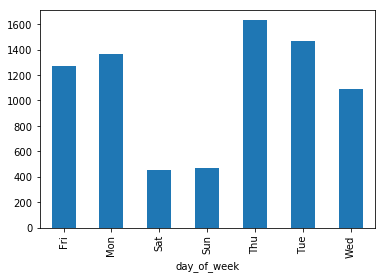

In [92]:
### First lets visualize it
chrome_df[['day_of_week', 'client_id']].groupby("day_of_week").agg(['count']).plot(kind="bar", legend=False)

In [124]:
### Well, that certainly seems to be the case. Lets prove it
from scipy.stats import ttest_ind

#### Get a testable count_per_week statistic
fri_count_per_week = chrome_df[chrome_df['day_of_week'] == 'Fri'].groupby(['month', 'day', 'day_of_week']).count()
sat_count_per_week = chrome_df[chrome_df['day_of_week'] == 'Sat'].groupby(['month', 'day', 'day_of_week']).count()

### test
ttest_ind(fri_count_per_week['url'], sat_count_per_week['url'])

Ttest_indResult(statistic=1.1721212863551969, pvalue=0.26218148417445453)

In [129]:
### What does this mean?
"""
Well, tl;dr. It means that we probably don't have enough data to make a statistically supported decision.

I think (from knowing my personal life), I spend a considerable less amount of time surfing the web during the weekends as opposed to the week.
Or maybe I jut dont even realize how much time I spend surfing the web on Sat compared to Friday. Also very likely.

But, what this test is telling us is a slightly different story. In truth, a slightly shorter story. As you may have noticed by the firsr bar graph that plotted
observations by month, I do not have a considerable amount of browsing data to work with.

Now let's get to it. What do the statistic and pvalue mean?

First, we'd have to go back to my hypothesis (I browse the web more on Friday than Saturday), and create a null hypothesis:

Null Hypothesis: I browse the web the same amount on Fridays and Saturdays.

Now, were ready to interpret the statistic. The statistic (1.1721212863551969) is a representation of the standard deviations away from our mean.
It doesn't mean a whole lot in and of itself, but we know that a statistic of 0 would mean that the data does not deviate from our null hypothesis.
i.e. a statistic of 0 would mean that Friday and Saturday have very similar (if not identical) browsing_counts_per_week

So, the p-value is a little more revealing. The pvalue gives us an idea of how confident we can be about the results. It gives us a sense of statistical significance.
What this pvalue (0.26218148417445453) is saying, is that there is a 26% chance that we are wrong in accepting our Alternative Hyposthesis
i.e I browse the web more on Fridays than Saturdays.

In reality, this is not a pvalue that we should comfortable accepting. This leaves a considerable chance of error. Maybe we wait for more data
"""

"\nWell, tl;dr. It means that we probably don't have enough data to make a statistically supported decision.\n\nI think (from knowing my personal life), I spend a considerable less amount of time surfing the web during the weekends as opposed to the week.\nOr maybe I jut dont even realize how much time I spend surfing the web on Sat compared to Friday. Also very likely.\n\nBut, what this test is telling us is a slightly different story. In truth, a slightly shorter story. As you may have noticed by the firsr bar graph that plotted\nobservations by month, I do not have a considerable amount of browsing data to work with.\n\nNow let's get to it. What do the statistic and pvalue mean?\n\nFirst, we'd have to go back to my hypothesis (I browse the web more on Friday than Saturday), and create a null hypothesis:\n\nNull Hypothesis: I browse the web the same amount on Fridays and Saturdays.\n\nNow, were ready to interpret the statistic. The statistic (1.1721212863551969) is a representation o